In [ ]:
import cv2  # type: ignore
import torch # type: ignore
import numpy as np # type: ignore
from PIL import Image # type: ignore
import torch.nn as nn # type: ignore
import matplotlib.pyplot as plt # type: ignore
import torch.nn.functional as F # type: ignore
import torchvision.models as models # type: ignore
import torchvision.transforms as transforms # type: ignore

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
def preprocess_img(img_path):
    # Step 1: Convert Image to Grayscale
    gray = img_path.convert("L")  # Convert to grayscale

    # Step 2: Convert Grayscale to NumPy Array
    img = np.array(gray)

    # Step 3: Morphological Transformation (Enhancing text regions)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 2))
    morphology_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Step 4: Apply Gaussian Blur (Smoothen the image)
    blur = cv2.GaussianBlur(morphology_img, (3, 3), 0)

    # Step 5: Detect Background Color & Apply Correct Thresholding
    mean_intensity = np.mean(blur)
    if mean_intensity < 127:
        # Dark background → Use THRESH_BINARY_INV to make text black
        _, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        # Light background → Use THRESH_BINARY to keep text black
        _, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 6: Find the Bounding Box Around Non-White Pixels (Text Area)
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)

    # Step 7: Adding Padding to the Bounding Box
    padding = 5
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    # Ensure the coordinates remain within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Step 8: Crop and Add Extra White Space
    cropped_image = binary[y:y + h, x:x + w]
    extra_space = np.ones((cropped_image.shape[0] + 2 * padding, cropped_image.shape[1] + 2 * padding), dtype=np.uint8) * 255
    extra_space[padding:-padding, padding:-padding] = cropped_image

    # Step 9: Resize Image to Standard Size
    corrected = cv2.resize(extra_space, (330, 175))

    # Step 10: Convert the NumPy Array Back to a PIL Image
    resized_image = Image.fromarray(corrected)

    return resized_image

In [78]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio = 16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size = 1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size = 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        avg_out = self.fc2(self.relu(self.fc1(avg_pool)))
        max_out = self.fc2(self.relu(self.fc1(max_pool)))
        attention = self.sigmoid(avg_out + max_out)
        return x * attention

In [79]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size = 7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size = kernel_size, padding = (kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_pool = torch.mean(x, dim = 1, keepdim = True)
        max_pool, _ = torch.max(x, dim = 1, keepdim = True)
        pool = torch.cat([avg_pool, max_pool], dim = 1)
        attention = self.sigmoid(self.conv(pool))
        return x * attention

In [80]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio = 16, spatial_kernel_size = 7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

In [81]:
class SiameseResNet(nn.Module):
    def __init__(self, model_name = "resnet50", pretrained = False):
        super(SiameseResNet, self).__init__()
        self.baseModel = models.resnet50(pretrained = pretrained)
        self.attention1 = CBAM(in_channels = 256)
        self.attention2 = CBAM(in_channels = 1024)

        self.baseModel.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.baseModel.fc = nn.Identity()
    def forward(self, x):
        out = self.baseModel.conv1(x)
        out = self.baseModel.bn1(out)
        out = self.baseModel.relu(out)
        out = self.baseModel.maxpool(out)

        out = self.attention1(self.baseModel.layer1(out))
        out = self.baseModel.layer2(out)

        out = self.attention2(self.baseModel.layer3(out))
        out = self.baseModel.layer4(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        return out

In [82]:
class LogisticSiameseRegression(nn.Module):
    def __init__(self, model):
        super(LogisticSiameseRegression, self).__init__()

        self.model = model
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(inplace = True),
            nn.Linear(256, 1),
            nn.LeakyReLU(inplace = True)
        )
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        out = self.model(x)
        out = F.normalize(out, p=2, dim=1)
        return out

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)

        diff = out1 - out2
        out = self.fc(diff)
        out = self.sigmoid(out)

        return out

In [ ]:
model_path = "./Files AI/resnet50_triangular_m1_ashoj10"

siamese_model = SiameseResNet()
siamese_model = nn.DataParallel(siamese_model).to(device)

siamese_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
model_path = "./Files AI/logistic_model_triangular_m09_ashoj3_v2.1.pth"

# Load the model
model_rms = LogisticSiameseRegression(siamese_model).to(device)
model_rms.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model_rms.to(device)

C:\Users\DELL\AppData\Local\Temp\ipykernel_31632\2249758542.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_rms.load_state_dict(torch.load(model_path, map_location

LogisticSiameseRegression(
  (model): DataParallel(
    (module): SiameseResNet(
      (baseModel): ResNet(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, moment

In [ ]:
def get_predictions_for_single(img1, img2, model):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    image1 = Image.open(img1)
    axes[0].imshow(image1)
    axes[0].axis("off")
    image1 = preprocess_img(image1)
    image2 = Image.open(img2)
    axes[1].imshow(image2)
    axes[1].axis("off")
    image2 = preprocess_img(image2)

    transform = transforms.Compose([
        transforms.Resize((175, 330)),
        transforms.ToTensor(),
    ])

    input1 = transform(image1).unsqueeze(0).to(device)
    input2 = transform(image2).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(input1, input2)

        pred1 = model.forward_once(input1)
        pred2 = model.forward_once(input2)
        diff = torch.pairwise_distance(pred1, pred2)
        similarity_score = 1 / (1 + diff)

        number1 = similarity_score.item()
        number2 = prediction.item()

        number1 *= 100
        number2 *= 100

        print("Similarity Percentage: ", f"{number1:.2f}%")
        print("")
        print("Probability Percentage: ", f"{number2:.2f}%")
        print("")

    if (number1 / 100) > 0.92 and (number2 / 100) > 0.92:
        print("The Signatures Are Similar.")
    else:
        print("The Signatures Are Not Similar.")

Similarity Percentage:  88.72%

Probability Percentage:  98.43%

The Signatures Are Not Similar.


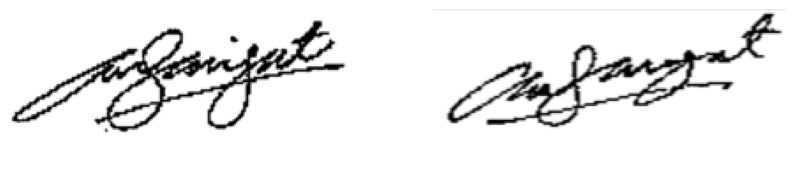

In [86]:
img1 = "./P-5/real.png"
img2 = "./P-5/skilled forgrey.png"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  94.30%

Probability Percentage:  99.10%

The Signatures Are Similar.


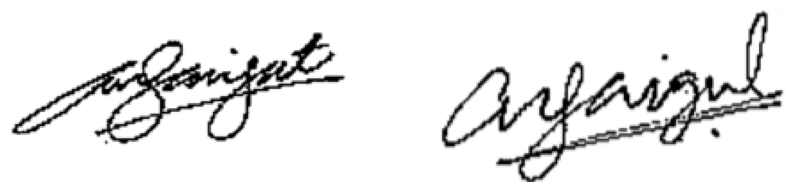

In [87]:
img1 = "./P-5/real.png"
img2 = "./P-5/unskilled forgrey.png"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  72.79%

Probability Percentage:  6.46%

The Signatures Are Not Similar.


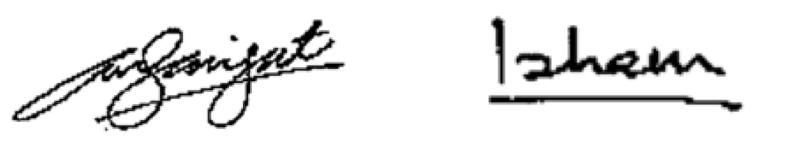

In [88]:
img1 = "./P-5/real.png"
img2 = "./P-5/random forgrey.png"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  95.47%

Probability Percentage:  99.12%

The Signatures Are Similar.


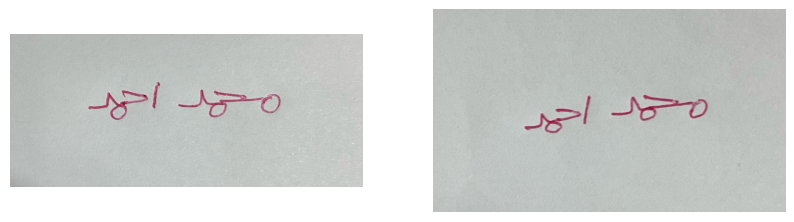

In [89]:
img1 = "./P-6/real 1.jpeg"
img2 = "./P-6/real 2.jpeg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  94.90%

Probability Percentage:  99.01%

The Signatures Are Similar.


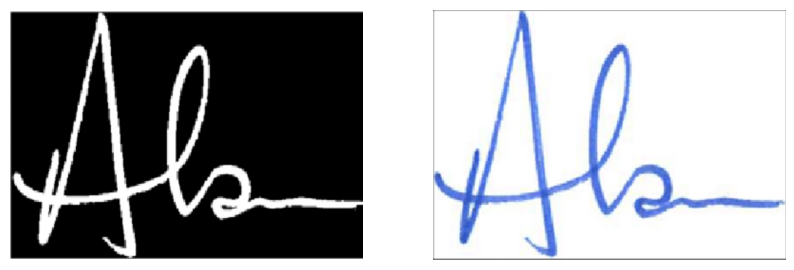

In [90]:
img1 = "./P-7/real 1.jpeg"
img2 = "./P-7/real 2.jpeg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  96.11%

Probability Percentage:  98.99%

The Signatures Are Similar.


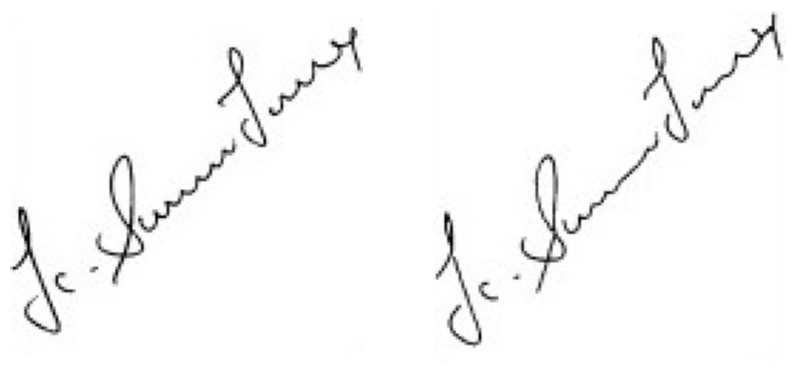

In [91]:
img1 = "./P-8/real.jpg"
img2 = "./P-8/skilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  94.78%

Probability Percentage:  98.89%

The Signatures Are Similar.


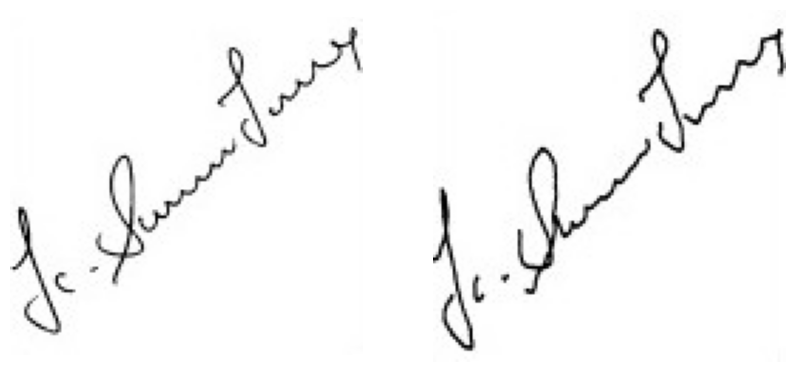

In [92]:
img1 = "./P-8/real.jpg"
img2 = "./P-8/unskilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  86.86%

Probability Percentage:  98.93%

The Signatures Are Not Similar.


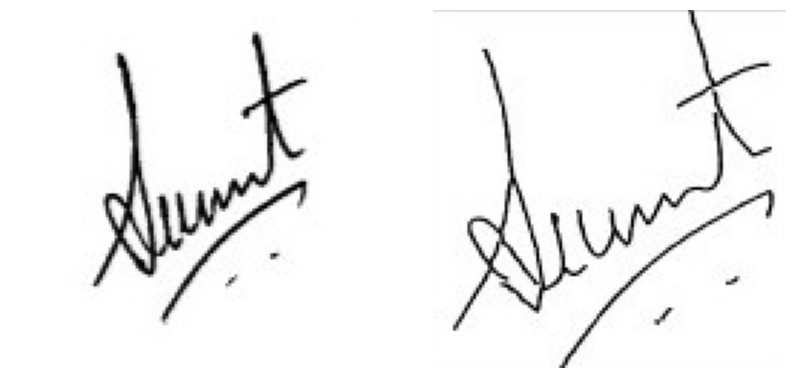

In [93]:
img1 = "./P-9/real.jpg"
img2 = "./P-9/skilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  90.16%

Probability Percentage:  98.98%

The Signatures Are Not Similar.


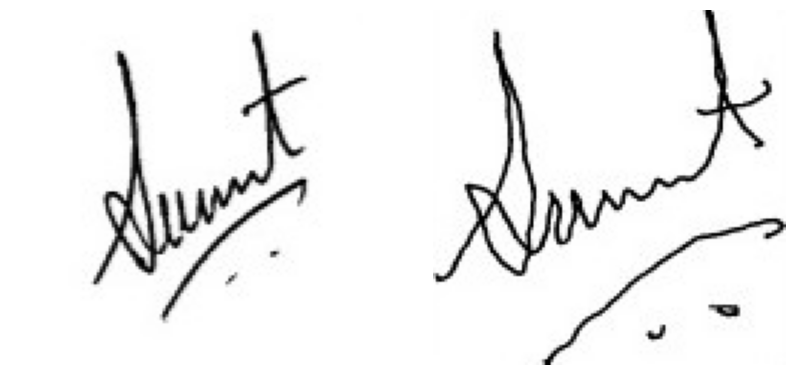

In [94]:
img1 = "./P-9/real.jpg"
img2 = "./P-9/unskilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  94.25%

Probability Percentage:  98.89%

The Signatures Are Similar.


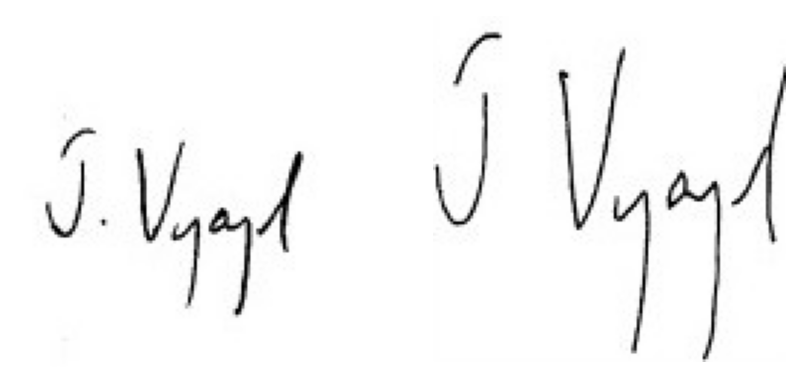

In [95]:
img1 = "./P-10/real.jpg"
img2 = "./P-10/skilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  92.46%

Probability Percentage:  98.77%

The Signatures Are Similar.


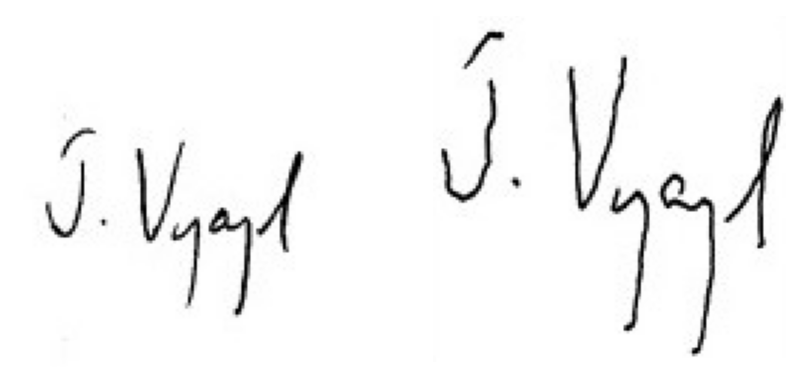

In [96]:
img1 = "./P-10/real.jpg"
img2 = "./P-10/unskilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  85.52%

Probability Percentage:  98.74%

The Signatures Are Not Similar.


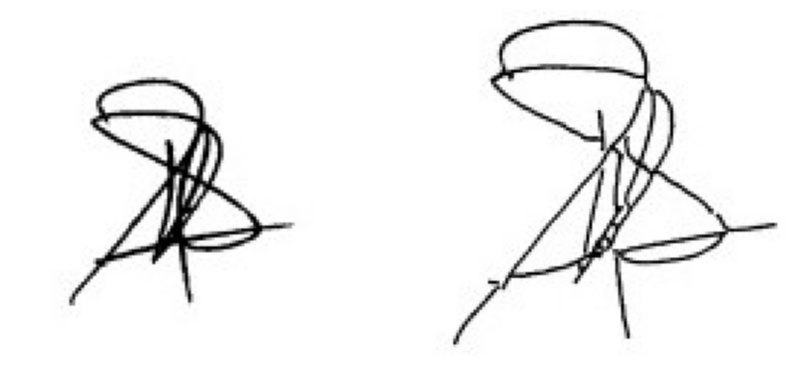

In [97]:
img1 = "./P-11/real.jpg"
img2 = "./P-11/skilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)

Similarity Percentage:  91.61%

Probability Percentage:  98.87%

The Signatures Are Not Similar.


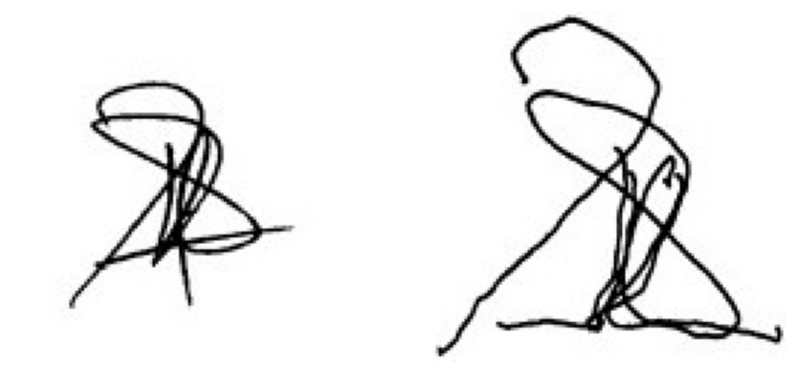

In [98]:
img1 = "./P-11/real.jpg"
img2 = "./P-11/unskilled forgrey.jpg"
get_predictions_for_single(img1, img2, model_rms)